## Importing modules

In [1]:
import pandas as pd
# import gseapy as gp
import matplotlib.pyplot as plt
# from gseapy.parser import Biomart
import os
import numpy as np
import seaborn as sns
# from gseapy.plot import gseaplot
from scipy import stats as st
import fnmatch
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Setting base directory

In [2]:
Base_dir='/data/nandas/Combined_coexp/Part_1_TranscriptionallyRegulatedGenes/Development/'
os.chdir(Base_dir)

In [3]:
mapper_df=pd.read_csv("/data/nandas/MEFIT/predicted/mapper_final.csv", header='infer',index_col=0)

In [4]:
mapper_df.index

Index(['WBGene00000156', 'WBGene00012005', 'WBGene00004775', 'WBGene00003842',
       'WBGene00003843', 'WBGene00007063', 'WBGene00200402', 'WBGene00044951',
       'WBGene00195865', 'WBGene00197051',
       ...
       'WBGene00012885', 'WBGene00012923', 'WBGene00013150', 'WBGene00021800',
       'WBGene00000371', 'WBGene00012553', 'WBGene00006519', 'WBGene00009161',
       'WBGene00017926', 'WBGene00010419'],
      dtype='object', name='Wormbase ID', length=31593)

## Functions

In [5]:
def wb_to_gene(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=1)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    wb_to_gene = {};
    for wb in mapper_df.index:
        wb_to_gene[wb] = str(mapper_df.loc[wb]['GeneName']);
    matrix=matrix.rename(index=wb_to_gene,columns=wb_to_gene)
    return matrix

def gene_to_wb(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=2)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    gene_to_wb = {};
    for gene in mapper_df.index:
        gene_to_wb[gene] = str(mapper_df.loc[gene]['WormBaseID']);
    matrix=matrix.rename(index=gene_to_wb,columns=gene_to_wb)
    return matrix

def SeqToWB(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Wb = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Wb[seq] = str(mapper_df.loc[seq]['WormBaseID']);
    matrix=matrix.rename(index=Seq_to_Wb,columns=Seq_to_Wb)
    return matrix

def SeqToGene(matrix):
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Gene = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Gene[seq] = str(mapper_df.loc[seq]['GeneName']);
    matrix=matrix.rename(index=Seq_to_Gene,columns=Seq_to_Gene)
    return matrix

def CalculateZScore(df):
    from scipy import stats
    Zscore=stats.zscore(df.values,axis=1,nan_policy='omit')
    ZScore_df=pd.DataFrame(Zscore,index=df.index,columns=df.columns)
    return ZScore_df

## Calculate coefficient of variation
def CalculateCoefVar(ZScore_df):
    Std=np.nanstd(ZScore_df.values,axis=1)
    Mean=ZScore_df.mean(axis=1,skipna=True)
    CoefVar=pd.DataFrame([])
#     from scipy.stats import variation 
#     Variation=variation(ZScore_df.values, axis = 1)
    CoefVar['CoefVar']=(Std/Mean)
    CoefVar.index=ZScore_df.index
    return CoefVar

def Log2Transform(df,title):
    #df=df.drop(columns=['GENEID','GENENAME'])
    fig=plt.figure(figsize=(4,3))
    df=df.stack()
    df=df.loc[~(df==0)]
    df=pd.DataFrame(df)
    df=df.applymap(np.log2)
    ## Plot the values of all cells in the dataframe to understand the distribution
    hist=df.hist(grid=False,bins=100,color='skyblue')
#     plt.axvline(1.3,color='r')
#     plt.axvline(df.mode()[1],color='g')
    plt.xlabel("log2(TPM)")
    plt.ylabel("Frequency")
    plt.title("{}".format(title))
    plt.savefig("{}.svg".format(title))
    return df,hist

def PlotCoefVar(CoefVar,xcoords):
    fig, ax = plt.subplots(figsize=(4,3))
    AllGenes=CoefVar.CoefVar.hist(ax=ax,color='green',bins=100,label='All genes',alpha=0.5)
    MetabolicGenes=CoefVar.loc[intersect2].hist(ax=ax,color='midnightblue',bins=100,label='Metabolic genes',alpha=0.5)  
    ax.grid(False)
    plt.title("Distribution of Coefficient of variation")
    ax.set_xlabel('Coefficient of Variation')
    ax.set_ylabel('Number of genes')
    for xc in xcoords:
        ax.axvline(xc,color='blue',linestyle='--')
    plt.legend(loc='best')
    plt.savefig("CoefVar.png", dpi=300)
    
def PlotDistributionofLogData(df,title):
    #df=df.drop(columns=['GENEID','GENENAME'])
    df=df.stack()
    df=df.loc[~(df==0)]
    df=pd.DataFrame(df)
    ## Plot the values of all cells in the dataframe to understand the distribution
    hist=df.hist(grid=False,bins=100,color='skyblue')
#     plt.axvline(1.3,color='r')
#     plt.axvline(df.mode()[1],color='g')
    plt.xlabel("log2(TPM)")
    plt.ylabel("Frequency")
    plt.title("{}".format(title))
    plt.savefig("{}.png".format(title))
    return df,hist


## Reading files

In [6]:
HighMod=pd.read_csv("/data/nandas/Transcription/KimDevTime_071620/HighModExpdata.csv",index_col=0)

In [7]:
Kim_data=pd.read_csv("/data/nandas/Transcription/KimDevTime_071620/HighModLowExpData.csv", index_col=0)

In [8]:
MetabolicClasses=pd.read_csv("/data/nandas/MetabolicClasses_August_SN_090221.csv",index_col=0)
MetabolicClasses=MetabolicClasses[~MetabolicClasses.index.duplicated(keep='first')]
mhm=list(set(MetabolicClasses.index).intersection(set(HighMod.index)))
MetabolicHighMod=HighMod.loc[mhm]

In [9]:
MetabolicHighMod

,DH2_N2_0,DH2_N2_2,DH2_N2_4,DH2_N2_6,DH2_N2_8,DH2_N2_10,DH2_N2_12,DH2_N2_14,DH2_N2_16,DH2_N2_18,...,DH2_N2_32,DH2_N2_34,DH2_N2_36,DH2_N2_38,DH5_N2_38,DH5_N2_40,DH5_N2_42,DH5_N2_44,DH5_N2_46,DH5_N2_48
WormBaseID,,,,,,,,,,,,,,,,,,,,,
WBGene00013880,4.070857,4.692496,4.757314,4.839082,4.848578,4.772199,4.570231,4.807354,4.744655,4.876850,...,5.488548,5.348013,5.289953,5.369373,5.422910,5.415463,5.456728,5.451840,5.435665,5.301169
WBGene00020366,6.071277,6.701075,6.650576,6.876742,6.433217,6.682785,7.323130,7.375658,7.047655,6.365882,...,6.836157,7.014957,7.062479,6.767366,6.942981,6.732259,6.294977,6.679978,7.000231,6.958145
WBGene00012017,1.733580,1.466941,1.362233,1.376593,1.025351,0.985422,0.867944,1.126529,0.796924,1.085996,...,0.959151,0.852572,0.722609,1.156934,1.218687,1.140066,0.991104,1.095401,0.924156,0.748504
WBGene00018657,5.300697,5.150314,5.122642,5.225316,4.819902,4.732327,4.372718,3.886899,4.071079,4.564206,...,4.453318,4.218556,4.238195,4.604445,4.406182,4.609153,5.108526,4.932782,4.087086,3.746172
WBGene00021394,4.744186,4.510584,4.373269,4.253232,4.498632,4.456886,4.626695,4.360812,4.191202,4.158450,...,4.361571,4.137536,4.082979,4.045252,4.070226,4.078827,4.375292,4.366645,4.387104,4.136176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00000240,5.150022,6.402329,6.196848,6.142160,5.800300,5.419960,5.021476,4.842393,4.866157,5.213683,...,5.745177,5.758320,5.815428,5.777291,5.689152,5.576539,5.817090,5.867878,5.546630,5.273518
WBGene00007228,4.017588,4.159874,3.864736,4.089264,3.616357,3.647530,4.397436,4.861259,4.627824,4.835204,...,4.515511,4.421677,4.356619,4.346755,4.750077,4.817801,4.154794,4.068499,3.795834,4.104113
WBGene00012750,3.526990,2.481412,2.682718,2.669223,2.151924,1.630290,0.133223,-1.748673,-1.382582,0.601253,...,0.753639,0.317160,-0.726710,0.306736,-1.395180,-0.573025,1.016432,0.910745,-0.570025,-1.521139


In [10]:
MetabolicHighMod.to_csv("KimMetabolicHighMod.csv")

In [22]:
# HighMod=gene_to_wb(HighMod)

In [23]:
# Tissue_exp=gene_to_wb(Tissue_exp)

## Calculating number of low expressed genes (both metabolic and non-metabolic)

In [11]:
totallowexpressed=list(set(Kim_data.index).difference(set(HighMod.index)))

In [12]:
len(totallowexpressed)

3552

In [13]:
Metabolic_genes=pd.read_csv("/data/nandas/MetabolicClasses_August_SN_090221.csv",index_col=0)

In [28]:
# Metabolic_genes=SeqToGene(Metabolic_genes)
# Metabolic_genes=gene_to_wb(Metabolic_genes)

In [29]:
# Metabolic_genes=wb_to_gene(Metabolic_genes)

In [15]:
intersect=list(set(Metabolic_genes.index).intersection(set(Kim_data.index)))

In [16]:
len(intersect)

2397

In [17]:
TotalMetabolicDevt=Kim_data.loc[intersect]

In [18]:
TotalMetabolicDevt=pd.DataFrame(TotalMetabolicDevt.index)

In [19]:
TotalMetabolicDevt

,WormBaseID
0,WBGene00013880
1,WBGene00020366
2,WBGene00012017
3,WBGene00018657
4,WBGene00021394
...,...
2392,WBGene00007228
2393,WBGene00008159
2394,WBGene00012750
2395,WBGene00000514


In [20]:
TotalMetabolicDevt.to_csv("TotalMetabolic_Devt.csv")

In [21]:
intersect2=list(set(Metabolic_genes.index).intersection(set(HighMod.index)))

In [22]:
len(intersect2)

2184

In [23]:
intersect2

['WBGene00013880',
 'WBGene00020366',
 'WBGene00012017',
 'WBGene00018657',
 'WBGene00021394',
 'WBGene00020386',
 'WBGene00019978',
 'WBGene00016762',
 'WBGene00009798',
 'WBGene00003594',
 'WBGene00016380',
 'WBGene00021932',
 'WBGene00013999',
 'WBGene00021566',
 'WBGene00000984',
 'WBGene00020068',
 'WBGene00007753',
 'WBGene00007435',
 'WBGene00015057',
 'WBGene00009773',
 'WBGene00001744',
 'WBGene00044058',
 'WBGene00008985',
 'WBGene00018708',
 'WBGene00011364',
 'WBGene00017092',
 'WBGene00001590',
 'WBGene00007331',
 'WBGene00008443',
 'WBGene00012803',
 'WBGene00021815',
 'WBGene00008410',
 'WBGene00015793',
 'WBGene00013561',
 'WBGene00005663',
 'WBGene00007942',
 'WBGene00007825',
 'WBGene00015125',
 'WBGene00021952',
 'WBGene00015161',
 'WBGene00010437',
 'WBGene00021430',
 'WBGene00021849',
 'WBGene00007509',
 'WBGene00017268',
 'WBGene00021260',
 'WBGene00008516',
 'WBGene00018931',
 'WBGene00010055',
 'WBGene00001769',
 'WBGene00022309',
 'WBGene00009543',
 'WBGene0001

In [24]:
totallowexpressed=pd.DataFrame(totallowexpressed)


In [25]:
totallowexpressed.set_axis(['Gene'],inplace=True,axis=1)

In [26]:
totallowexpressed.shape[0]

3552

In [42]:
## Filtering genes that have atleast HIGH expression in

In [27]:
metaboliclowexpressed=list(set(Metabolic_genes.index).intersection(set(totallowexpressed.Gene)))

In [28]:
len(metaboliclowexpressed)

213

In [29]:
totallowexpressed['Gene'].values

array(['WBGene00016886', 'WBGene00005062', 'WBGene00007083', ...,
       'WBGene00005808', 'WBGene00009167', 'WBGene00005299'], dtype=object)

<Figure size 288x216 with 0 Axes>

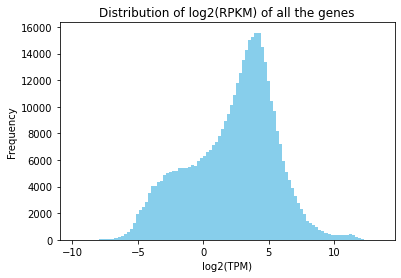

In [30]:
LogTransformed,hist=Log2Transform(Kim_data,title="Distribution of log2(RPKM) of all the genes")

/home/nandas/miniconda3/envs/metabolism/lib/python3.6/site-packages/pandas/core/frame.py:7596: RuntimeWarning: invalid value encountered in log2
  return lib.map_infer(x.astype(object)._values, func)


<Figure size 288x216 with 0 Axes>

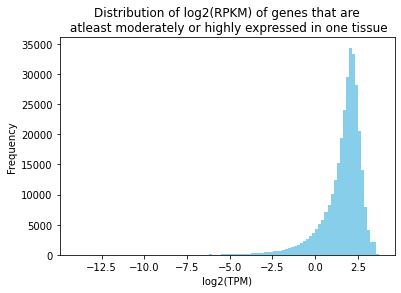

In [31]:
LogTransformed_HighMod,hist_HighMod=Log2Transform(HighMod,
                                                  "Distribution of log2(RPKM) of genes that are\n atleast moderately or highly expressed in one tissue")

In [49]:
# New_df=LogTransformed.unstack()

In [50]:
# def FilterData(TransformedData):
#     TransformedData.fillna(0,inplace=True)
#     Filtered_TransformedData=TransformedData.loc[TransformedData.index[(((TransformedData.values>1.3).sum(axis=1))
#                             ==(TransformedData.shape[1]))==True]]
#     return Filtered_TransformedData


In [51]:
# New_df=FilterData(New_df)

In [52]:
# New_df.shape

In [53]:
# New_df

In [54]:
# TissueSets=pd.read_excel("/data/nandas/Resolve_OR_genes/TissueSets.xlsx",index_col=0)

## Extracting metabolic genes

In [32]:
MetabolicClasses=pd.read_csv("/data/nandas/MetabolicClasses_August_SN_090221.csv",index_col=0)

In [33]:
MetabolicClasses

,Sequence Name,Class,Molecular Function,iCEL1273 description / Notes,Wormbase Description Text
Gene Name,,,,,
WBGene00017071,D2096.3,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-1 is an ortholog of human SI (sucrase-iso...
WBGene00019895,R05F9.12,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-2 is an ortholog of human SI (sucrase-iso...
WBGene00009583,F40F9.6,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-3 is an ortholog of human GANC (glucosida...
WBGene00018682,F52D1.1,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-4 is an ortholog of human GANC (glucosida...
WBGene00000001,Y110A7A.10,A,phosphoinositide 3-kinase,Inositol phosphate metabolism,aap-1 encodes the C. elegans ortholog of the p...
...,...,...,...,...,...
WBGene00009078,F23B2.13,A,NaN,NaN,NaN
WBGene00000366,R10E11.1,A,NaN,NaN,NaN
WBGene00016603,C43E11.3,A,NaN,NaN,NaN


## Convert WBIDs of matrix to Gene Symbols

In [38]:
HighMod=Kim_data.loc[HighMod.index]

In [40]:
CoefVar_HighMod=CalculateCoefVar(HighMod)

In [39]:
HighMod

,DH2_N2_0,DH2_N2_2,DH2_N2_4,DH2_N2_6,DH2_N2_8,DH2_N2_10,DH2_N2_12,DH2_N2_14,DH2_N2_16,DH2_N2_18,...,DH2_N2_32,DH2_N2_34,DH2_N2_36,DH2_N2_38,DH5_N2_38,DH5_N2_40,DH5_N2_42,DH5_N2_44,DH5_N2_46,DH5_N2_48
WormBaseID,,,,,,,,,,,,,,,,,,,,,
WBGene00007227,70.615819,67.609032,68.980156,68.248106,64.837985,63.665339,63.620106,60.588191,71.601861,68.539441,...,37.388512,41.614255,46.115568,44.492279,46.980068,52.574661,46.247786,39.089218,35.029003,35.853226
WBGene00019836,11.821903,30.965080,26.909551,21.406030,23.890943,18.756760,14.773205,20.094695,20.364188,26.376493,...,26.511306,24.610876,24.617939,28.124247,29.074190,27.224087,26.006861,23.390912,25.870434,25.445235
WBGene00000292,105.331902,126.146530,113.875400,99.466931,96.493245,92.483081,94.359485,95.211110,98.193687,92.802552,...,94.377819,90.567975,85.521647,87.263552,90.664864,88.358284,88.304613,86.862403,87.522572,82.865958
WBGene00006467,19.548932,20.670068,15.584429,14.737452,13.117938,11.464553,11.662235,11.126424,12.060973,19.237292,...,9.023820,7.741497,9.826050,12.841537,16.956458,15.617446,14.300727,9.528738,7.361606,6.876232
WBGene00017226,3.999935,4.423834,5.297654,3.481761,1.817581,1.465604,1.040239,0.742126,0.803720,1.024656,...,0.597018,0.378991,0.265661,0.801174,0.651872,0.686036,0.792779,0.764313,0.692963,0.543066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00001054,10.224099,11.348181,9.342223,11.268721,11.391288,12.670076,10.990533,14.089706,18.692573,16.236861,...,7.273015,10.242219,12.195801,10.011724,12.756997,12.591340,7.009737,6.624018,6.989199,12.830576
WBGene00008216,3.108658,7.208310,6.450149,4.627157,2.462255,5.263717,10.709566,6.847871,6.033098,2.147266,...,3.111543,3.124692,2.709059,1.761628,1.809364,2.273601,3.171561,4.622945,3.321915,2.221810
WBGene00010769,138.967582,124.129728,115.680265,182.666597,75.925469,96.227153,92.487840,167.140446,53.197335,42.951126,...,23.971839,25.214695,23.397616,33.478864,29.466143,28.590079,37.306387,54.588269,54.280469,40.413380


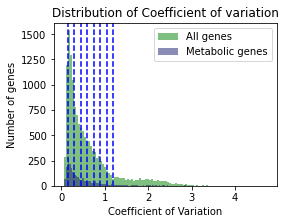

In [41]:
PlotCoefVar(CoefVar_HighMod,xcoords=[0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2])

## Defining genes as regulated using different CVs

In [42]:
def Cutoff(CoefVar_HighMod,cutoff):
    print(cutoff)
    CoefVar_1=CoefVar_HighMod[CoefVar_HighMod.CoefVar>=cutoff]
    return CoefVar_1,cutoff

In [43]:
def PlotRegulatedMetabolic(val1,cutoff,lowexpressed,HighMod):
    fig, ax = plt.subplots(figsize=(12,10))

    size = 0.3
    vals = [val1,(HighMod.shape[0]-val1),lowexpressed]
    outer_labels=["Regulated", "Non Regulated","Low expressed"]
    print(vals)

    explode = (0.1, 0)
    cmap = plt.get_cmap("tab20c")
    outer_colors = ['#54CB73','red','blue']
    ax.pie(vals, radius=1, labels=outer_labels, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w',linewidth=3),autopct='%1.1f%%',shadow=False,
           textprops={'size': 'larger','fontweight':'bold'},
          pctdistance=0.85,labeldistance=1.05,startangle=90,counterclock=False)
    plt.title("Percentage of transcriptionally regulated genes across tissues with cutoff {}".format(cutoff),fontweight="bold",fontsize=12)

In [44]:
NonMetabolicHighMod=list(set(HighMod.index).difference(set(MetabolicClasses.index)))

In [45]:
NonMetabolicHighMod=HighMod.loc[NonMetabolicHighMod]

In [46]:
NonMetabolicHighMod

,DH2_N2_0,DH2_N2_2,DH2_N2_4,DH2_N2_6,DH2_N2_8,DH2_N2_10,DH2_N2_12,DH2_N2_14,DH2_N2_16,DH2_N2_18,...,DH2_N2_32,DH2_N2_34,DH2_N2_36,DH2_N2_38,DH5_N2_38,DH5_N2_40,DH5_N2_42,DH5_N2_44,DH5_N2_46,DH5_N2_48
WormBaseID,,,,,,,,,,,,,,,,,,,,,
WBGene00016641,10.264783,14.830837,17.310685,23.154789,51.845991,65.202916,65.901089,47.971784,38.250687,39.501867,...,82.148689,67.308648,50.825187,47.939935,40.263243,40.090271,52.195027,65.768513,53.545432,33.139625
WBGene00003485,45.280342,146.052516,110.332396,207.861597,309.714220,303.263134,154.336205,95.942544,77.113497,52.473242,...,149.313468,171.067276,141.161773,113.663001,67.726694,62.154827,147.707758,194.629025,190.923978,131.274079
WBGene00020689,10.973593,8.191527,8.820917,9.025842,8.565349,8.955167,9.234969,8.909571,10.107486,7.601293,...,4.023847,4.439323,4.956011,3.986156,4.514959,5.292846,4.935094,4.439384,4.825644,4.915306
WBGene00021070,1.374484,7.136777,8.076960,11.054972,9.539575,14.142749,13.350072,11.705154,10.038879,10.092785,...,26.608319,24.087601,19.889120,22.464848,20.802617,21.365213,26.767976,30.376497,28.498258,22.029146
WBGene00014997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123608,NaN,NaN,...,0.083738,0.045909,0.070797,0.313982,0.248172,0.255954,0.308103,1.062704,2.945936,8.719610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00003010,49.549810,82.287239,72.774159,71.209805,63.583718,63.996064,47.425194,36.263600,41.940734,38.310086,...,27.229412,21.792916,21.815407,25.768459,22.853805,24.568941,28.358408,28.160086,22.669885,19.887052
WBGene00021791,0.046498,0.287422,0.089100,0.283322,0.165781,0.062624,0.094880,0.073330,0.057757,NaN,...,0.074516,0.190646,0.126000,1.862690,1.104202,1.127983,4.935094,35.304924,304.198146,617.067704
WBGene00008107,4.852784,10.995485,14.169788,15.254572,18.834518,19.607085,19.190145,14.289087,12.055611,9.483744,...,12.289608,14.230823,13.812593,12.787726,13.119220,13.086885,13.960650,14.080989,18.287415,17.094789


In [48]:
NonMetabolicDevtExp=list(set(Kim_data.index).difference(set(MetabolicClasses.index)))
NonMetabolicDevtExp=Kim_data.loc[NonMetabolicDevtExp]

In [49]:
NonMetabolicDevtExp

,DH2_N2_0,DH2_N2_2,DH2_N2_4,DH2_N2_6,DH2_N2_8,DH2_N2_10,DH2_N2_12,DH2_N2_14,DH2_N2_16,DH2_N2_18,...,DH2_N2_32,DH2_N2_34,DH2_N2_36,DH2_N2_38,DH5_N2_38,DH5_N2_40,DH5_N2_42,DH5_N2_44,DH5_N2_46,DH5_N2_48
WormBaseID,,,,,,,,,,,,,,,,,,,,,
WBGene00003485,45.280342,146.052516,110.332396,207.861597,309.714220,303.263134,154.336205,95.942544,77.113497,52.473242,...,149.313468,171.067276,141.161773,113.663001,67.726694,62.154827,147.707758,194.629025,190.923978,131.274079
WBGene00020689,10.973593,8.191527,8.820917,9.025842,8.565349,8.955167,9.234969,8.909571,10.107486,7.601293,...,4.023847,4.439323,4.956011,3.986156,4.514959,5.292846,4.935094,4.439384,4.825644,4.915306
WBGene00021070,1.374484,7.136777,8.076960,11.054972,9.539575,14.142749,13.350072,11.705154,10.038879,10.092785,...,26.608319,24.087601,19.889120,22.464848,20.802617,21.365213,26.767976,30.376497,28.498258,22.029146
WBGene00014997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123608,NaN,NaN,...,0.083738,0.045909,0.070797,0.313982,0.248172,0.255954,0.308103,1.062704,2.945936,8.719610
WBGene00011921,0.226919,0.116889,0.072470,0.098761,NaN,0.076403,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448681,0.445538,0.733240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00003010,49.549810,82.287239,72.774159,71.209805,63.583718,63.996064,47.425194,36.263600,41.940734,38.310086,...,27.229412,21.792916,21.815407,25.768459,22.853805,24.568941,28.358408,28.160086,22.669885,19.887052
WBGene00009167,0.507431,0.627321,0.648227,0.574204,0.603050,0.649234,0.138055,0.120036,0.378178,0.339968,...,0.596333,0.297214,0.297923,0.162619,0.214223,0.473445,0.313449,0.172000,0.170795,0.187389
WBGene00021791,0.046498,0.287422,0.089100,0.283322,0.165781,0.062624,0.094880,0.073330,0.057757,NaN,...,0.074516,0.190646,0.126000,1.862690,1.104202,1.127983,4.935094,35.304924,304.198146,617.067704


In [50]:
NonMetabolicLowExpressed=list(set(NonMetabolicDevtExp.index).difference(set(NonMetabolicHighMod.index)))
NonMetabolicLowExpressed=NonMetabolicDevtExp.loc[NonMetabolicLowExpressed]

In [51]:
NonMetabolicLowExpressed

,DH2_N2_0,DH2_N2_2,DH2_N2_4,DH2_N2_6,DH2_N2_8,DH2_N2_10,DH2_N2_12,DH2_N2_14,DH2_N2_16,DH2_N2_18,...,DH2_N2_32,DH2_N2_34,DH2_N2_36,DH2_N2_38,DH5_N2_38,DH5_N2_40,DH5_N2_42,DH5_N2_44,DH5_N2_46,DH5_N2_48
WormBaseID,,,,,,,,,,,,,,,,,,,,,
WBGene00016886,0.781771,1.323157,1.070023,0.097214,0.066363,NaN,0.075962,NaN,NaN,0.074824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WBGene00005062,0.397480,0.526491,0.544037,0.494268,0.472380,0.152949,0.231731,0.179098,0.141064,0.304346,...,0.151662,0.066518,0.051290,0.090987,0.089895,0.079470,0.063774,0.032079,0.095562,0.026212
WBGene00007083,0.573123,0.421746,0.889035,0.213804,NaN,NaN,NaN,NaN,NaN,0.109709,...,0.043736,NaN,NaN,NaN,0.043206,NaN,NaN,NaN,NaN,NaN
WBGene00001964,0.258289,0.304110,0.117842,NaN,NaN,0.024847,NaN,NaN,NaN,NaN,...,0.019711,NaN,NaN,NaN,NaN,NaN,NaN,0.020845,NaN,NaN
WBGene00015165,0.170765,0.175926,0.196332,0.118914,0.081177,0.091994,0.092919,NaN,NaN,0.091527,...,NaN,0.040008,0.077122,0.109451,0.108138,0.127462,0.210968,0.308707,0.728044,1.891852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00021488,NaN,0.327828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WBGene00006006,0.772632,0.729653,0.205628,0.392316,0.382594,0.563645,0.437933,0.609237,0.559832,NaN,...,0.103182,0.075425,0.145394,0.051585,0.169887,0.150184,0.072313,0.363740,0.036119,0.118886
WBGene00005808,0.406285,0.313924,0.097316,0.088413,NaN,0.102597,NaN,0.040046,NaN,NaN,...,NaN,NaN,0.022936,NaN,0.053601,NaN,NaN,NaN,NaN,NaN


In [52]:
NonMetabolicCoefVar_HighMod=CoefVar_HighMod.loc[NonMetabolicHighMod.index]

In [53]:
NonMetabolicCoefVar_HighMod

,CoefVar
WormBaseID,
WBGene00016641,0.406113
WBGene00003485,0.464669
WBGene00020689,0.319641
WBGene00021070,0.418749
WBGene00014997,2.102030
...,...
WBGene00003010,0.453489
WBGene00021791,3.265585
WBGene00008107,0.273662


## Plotting percentage regulated non-metabolic genes with different CV cutoffs

0.15
[11141, 1236, 3339]


WormBaseID
WBGene00015353    0.150004
WBGene00016209    0.150006
WBGene00004918    0.150026
WBGene00018974    0.150028
WBGene00004323    0.150142
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 11141, dtype: float64

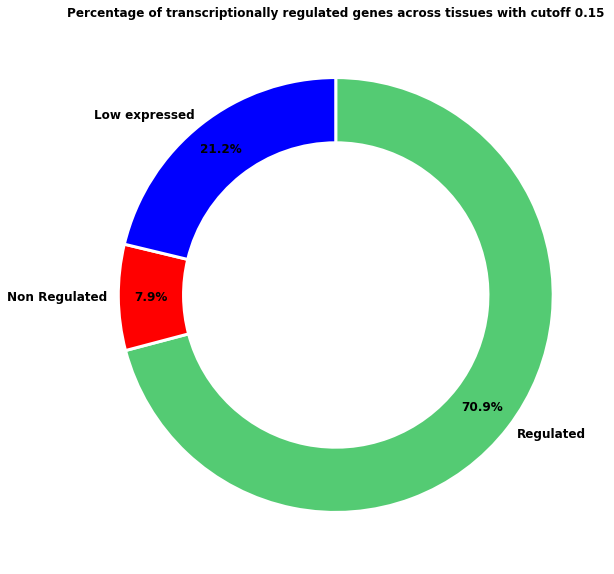

In [54]:
#Cutoff 0.15
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.15)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.3
[7919, 4458, 3339]


WormBaseID
WBGene00015155    0.300108
WBGene00001622    0.300324
WBGene00044774    0.300446
WBGene00003878    0.300506
WBGene00010479    0.300585
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 7919, dtype: float64

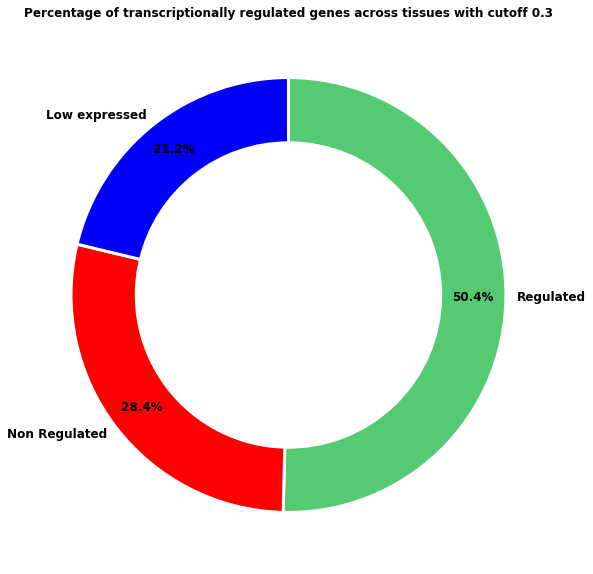

In [55]:
#Cutoff 0.3
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.3)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.45
[6109, 6268, 3339]


WormBaseID
WBGene00014210    0.450082
WBGene00003915    0.450117
WBGene00015952    0.450148
WBGene00044458    0.450334
WBGene00020456    0.450660
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 6109, dtype: float64

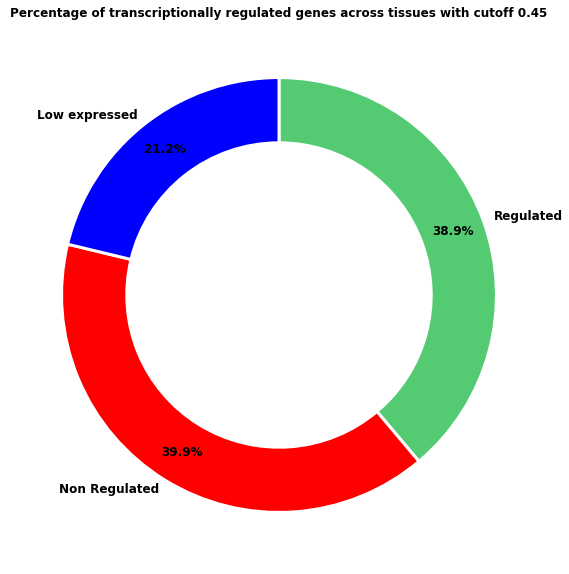

In [56]:
#Cutoff 0.45
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.45)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.6
[4714, 7663, 3339]


WormBaseID
WBGene00008075    0.600071
WBGene00021274    0.600466
WBGene00006766    0.600490
WBGene00007515    0.600689
WBGene00010146    0.600744
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 4714, dtype: float64

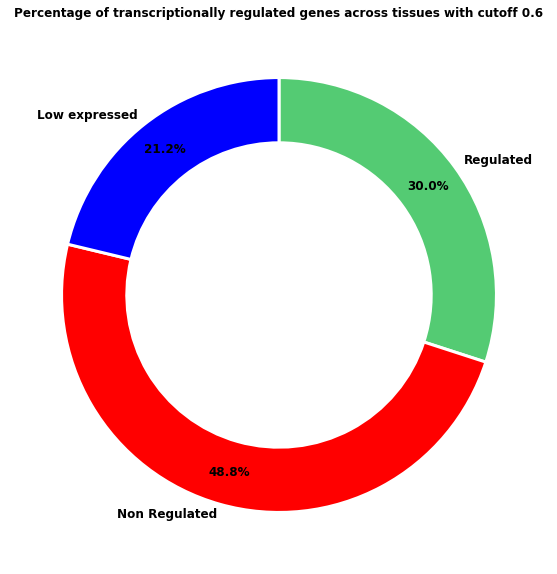

In [57]:
#Cutoff 0.6
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.6)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.75
[3609, 8768, 3339]


WormBaseID
WBGene00016514    0.750465
WBGene00017806    0.750794
WBGene00008064    0.750979
WBGene00008093    0.751066
WBGene00017666    0.751124
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 3609, dtype: float64

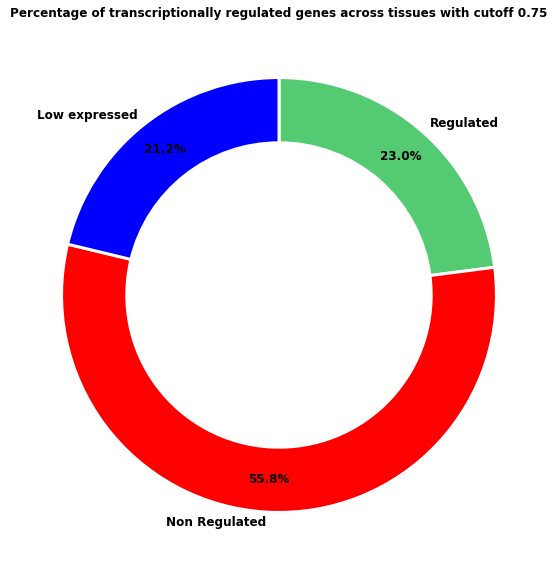

In [58]:
#Cutoff 0.75
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.75)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.9
[2777, 9600, 3339]


WormBaseID
WBGene00017785    0.900124
WBGene00000439    0.900359
WBGene00004118    0.901026
WBGene00050943    0.901387
WBGene00001534    0.901831
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 2777, dtype: float64

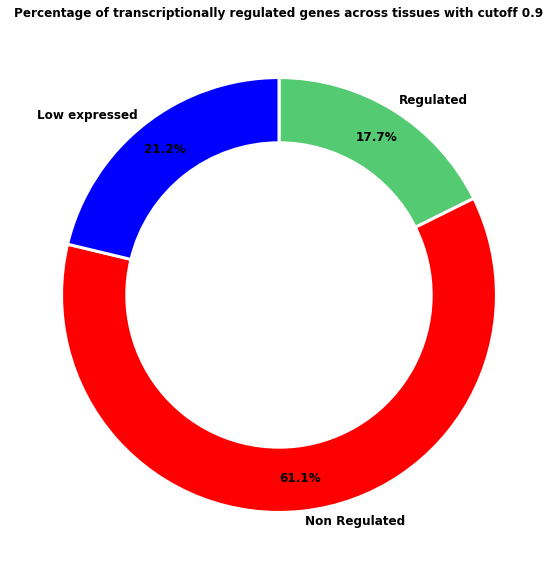

In [59]:
#Cutoff 0.9
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=0.9)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.05
[2162, 10215, 3339]


WormBaseID
WBGene00010987    1.050455
WBGene00008937    1.050529
WBGene00015117    1.050592
WBGene00017212    1.051205
WBGene00009791    1.051605
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 2162, dtype: float64

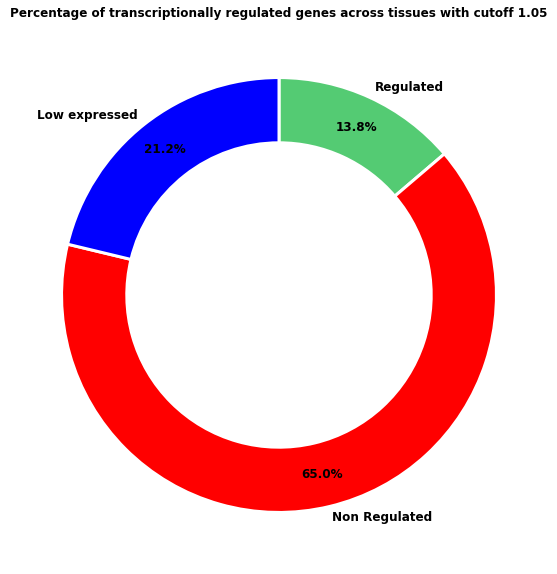

In [60]:
#Cutoff 1.05
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=1.05)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.2
[1831, 10546, 3339]


WormBaseID
WBGene00013590    1.200688
WBGene00019089    1.201312
WBGene00022680    1.201488
WBGene00012300    1.202966
WBGene00015544    1.203324
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 1831, dtype: float64

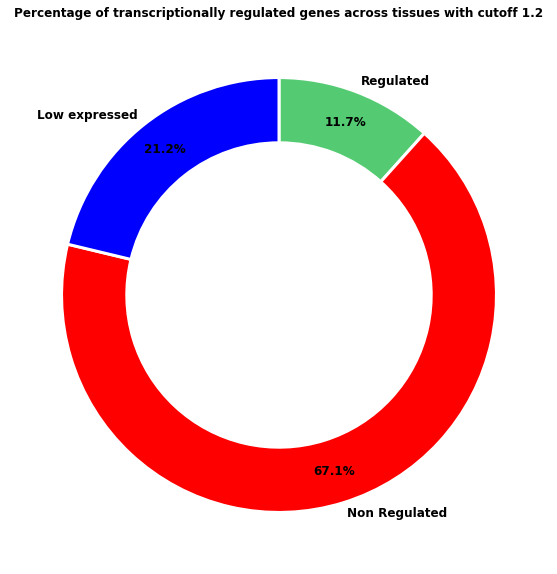

In [61]:
#Cutoff 1.2
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=NonMetabolicCoefVar_HighMod,cutoff=1.2)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=NonMetabolicLowExpressed.shape[0],HighMod=NonMetabolicHighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

## Plotting percentage regulated with different CV cutoffs for all genes

0.15
[13026, 1535, 3552]


WormBaseID
WBGene00015353    0.150004
WBGene00016209    0.150006
WBGene00009146    0.150021
WBGene00004918    0.150026
WBGene00018974    0.150028
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 13026, dtype: float64

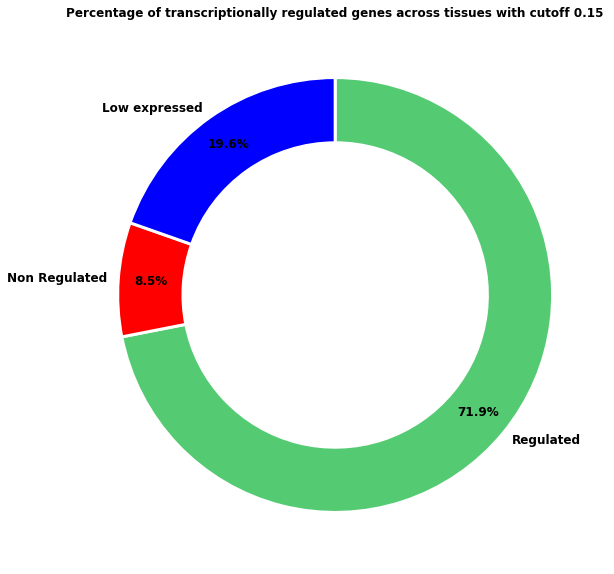

In [62]:

#Cutoff 0.15
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.15)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

#### Cutoff 0.3

0.3
[9015, 5546, 3552]


WormBaseID
WBGene00015155    0.300108
WBGene00011164    0.300199
WBGene00001622    0.300324
WBGene00044774    0.300446
WBGene00003878    0.300506
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 9015, dtype: float64

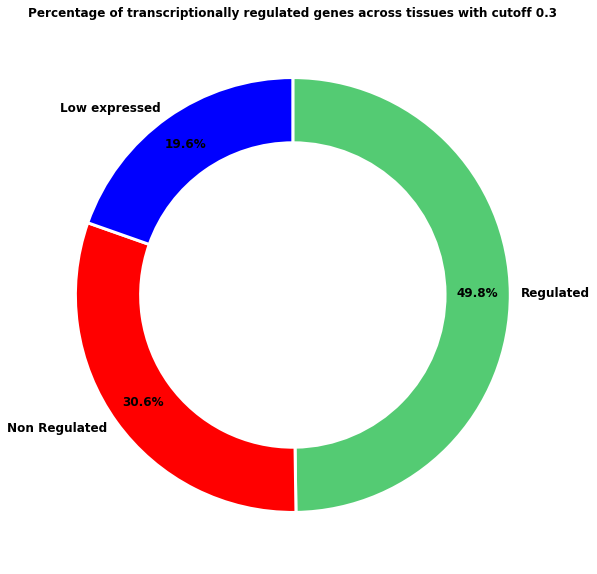

In [63]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.3)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

#### Cutoff 0.45

0.45
[6859, 7702, 3552]


WormBaseID
WBGene00014210    0.450082
WBGene00003915    0.450117
WBGene00015952    0.450148
WBGene00044458    0.450334
WBGene00009818    0.450577
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 6859, dtype: float64

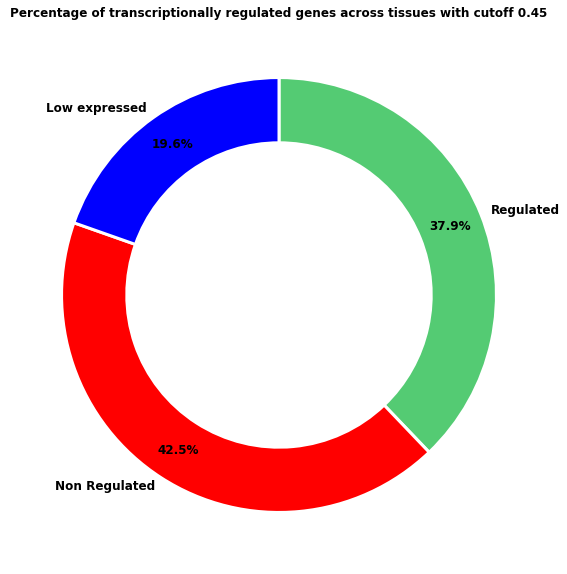

In [64]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.45)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.6
[5235, 9326, 3552]


WormBaseID
WBGene00008075    0.600071
WBGene00021274    0.600466
WBGene00006766    0.600490
WBGene00007515    0.600689
WBGene00010146    0.600744
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 5235, dtype: float64

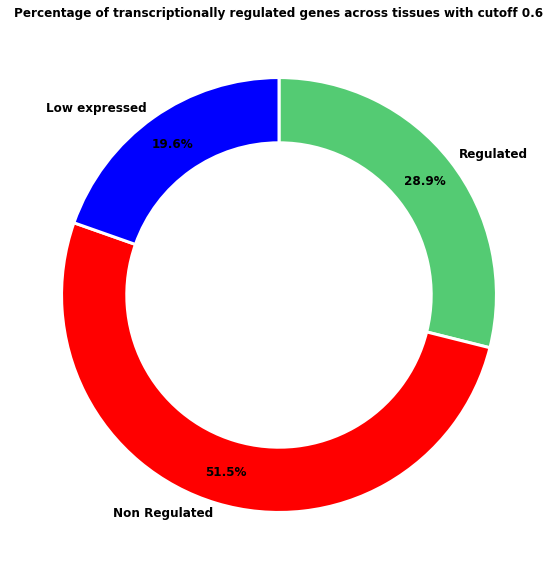

In [65]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.6)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.75
[3971, 10590, 3552]


WormBaseID
WBGene00016514    0.750465
WBGene00017806    0.750794
WBGene00008064    0.750979
WBGene00008093    0.751066
WBGene00017666    0.751124
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 3971, dtype: float64

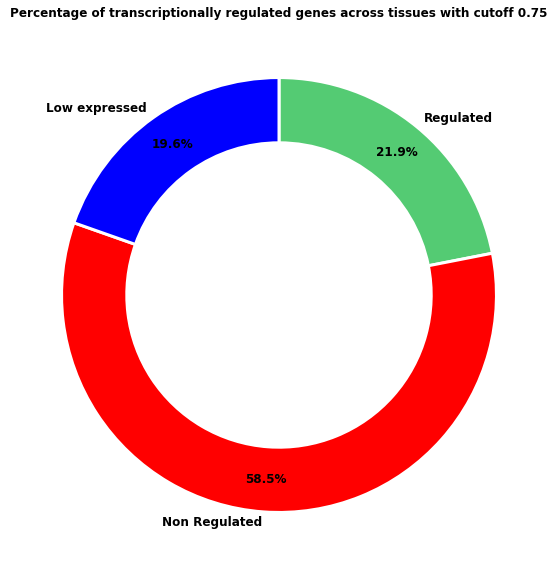

In [66]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.75)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.9
[3009, 11552, 3552]


WormBaseID
WBGene00017785    0.900124
WBGene00000439    0.900359
WBGene00022814    0.900741
WBGene00004118    0.901026
WBGene00050943    0.901387
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 3009, dtype: float64

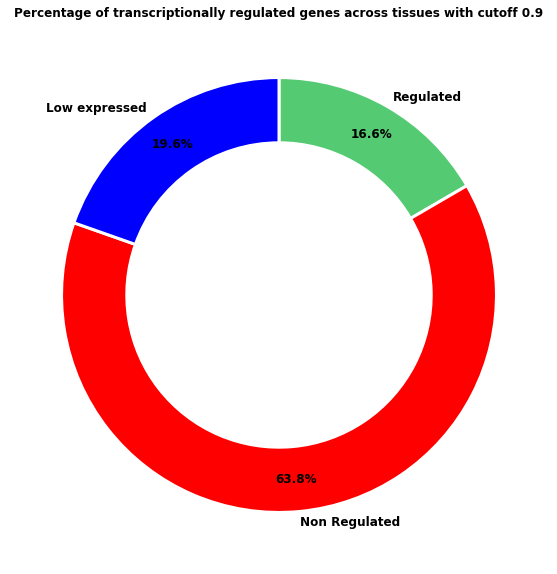

In [67]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=0.9)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.05
[2332, 12229, 3552]


WormBaseID
WBGene00010987    1.050455
WBGene00008937    1.050529
WBGene00015117    1.050592
WBGene00017212    1.051205
WBGene00009791    1.051605
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 2332, dtype: float64

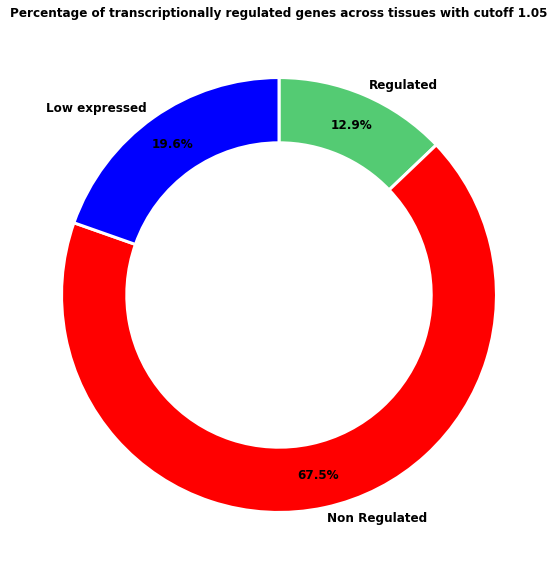

In [68]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=1.05)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.2
[1968, 12593, 3552]


WormBaseID
WBGene00013590    1.200688
WBGene00019089    1.201312
WBGene00022680    1.201488
WBGene00012300    1.202966
WBGene00015544    1.203324
                    ...   
WBGene00000712    4.478181
WBGene00000754    4.494656
WBGene00000663    4.494757
WBGene00000713    4.543391
WBGene00020700    4.726389
Name: CoefVar, Length: 1968, dtype: float64

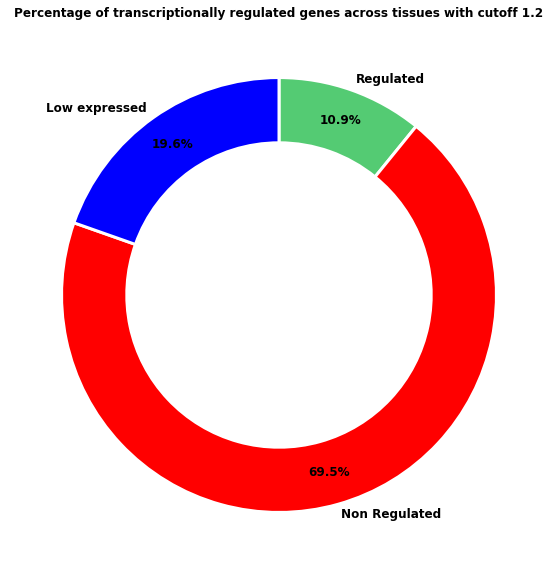

In [69]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=CoefVar_HighMod,cutoff=1.2)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=totallowexpressed.shape[0],HighMod=HighMod)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

In [70]:
Threshold_1_2=MetabolicCoefVar[MetabolicCoefVar.CoefVar>=0.9].sort_values(by=['CoefVar'])

NameError: name 'MetabolicCoefVar' is not defined

In [202]:
Threshold_1_2['Class']=MetabolicClasses['Class']

In [203]:
Threshold_1_2

,CoefVar,Class
gene_id,,
WBGene00000392,0.900662,A
WBGene00003214,0.902059,A
WBGene00017921,0.902197,B
WBGene00009554,0.903520,A
WBGene00016704,0.903713,A
...,...,...
WBGene00000977,2.449490,C
WBGene00013950,2.449490,C
WBGene00001765,2.449490,C


In [86]:
# Regulated_number=(CoefVar_1.shape[0])/(CoefVar_HighMod.shape[0])

In [87]:
# Regulated_number

## Finding metabolic genes as regulated

In [153]:
    MetabolicClasses=pd.read_csv("/data/nandas/MetabolicClasses_August_SN_090221.csv",index_col=0)

In [71]:
MetabolicClasses

,Sequence Name,Class,Molecular Function,iCEL1273 description / Notes,Wormbase Description Text
Gene Name,,,,,
WBGene00017071,D2096.3,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-1 is an ortholog of human SI (sucrase-iso...
WBGene00019895,R05F9.12,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-2 is an ortholog of human SI (sucrase-iso...
WBGene00009583,F40F9.6,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-3 is an ortholog of human GANC (glucosida...
WBGene00018682,F52D1.1,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-4 is an ortholog of human GANC (glucosida...
WBGene00000001,Y110A7A.10,A,phosphoinositide 3-kinase,Inositol phosphate metabolism,aap-1 encodes the C. elegans ortholog of the p...
...,...,...,...,...,...
WBGene00009078,F23B2.13,A,NaN,NaN,NaN
WBGene00000366,R10E11.1,A,NaN,NaN,NaN
WBGene00016603,C43E11.3,A,NaN,NaN,NaN


In [72]:
Metabolic_HighMod_Class=MetabolicClasses.loc[intersect2]

In [73]:
Metabolic_HighMod_Class=Metabolic_HighMod_Class.Class

In [74]:
Metabolic_HighMod_Class=pd.DataFrame(Metabolic_HighMod_Class)

In [75]:
Metabolic_HighMod_Class

,Class
Gene Name,
WBGene00013880,C
WBGene00020366,A
WBGene00012017,A
WBGene00018657,A
WBGene00021394,C
...,...
WBGene00000240,A
WBGene00007228,C
WBGene00012750,B


In [76]:
MetabolicCoefVar=CoefVar_HighMod.loc[intersect2]

In [77]:
MetabolicCoefVar.shape

(2184, 1)

In [78]:


Metabolic_HighMod_Class['CV']=MetabolicCoefVar['CoefVar']

In [97]:
# Metabolic_HighMod_Class=wb_to_gene(Metabolic_HighMod_Class)

In [79]:
Metabolic_HighMod_Class[Metabolic_HighMod_Class.CV>=0.75].sort_values(by=['CV'])

,Class,CV
Gene Name,,
WBGene00004933,A,0.751816
WBGene00009218,A,0.753103
WBGene00013865,C,0.753729
WBGene00000986,C,0.753987
WBGene00015400,A,0.754248
...,...,...
WBGene00001782,C,2.878493
WBGene00018143,C,2.902142
WBGene00017659,D,2.997630


## Calculating transcriptionally regulated for metabolic genes only

In [80]:
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.75)

0.75


In [81]:
intersect3=list(set(CoefVar_1.index).intersection(set(intersect2)))
RegulatedMetabolic=Metabolic_HighMod_Class.loc[intersect3]

In [101]:
# RegulatedMetabolic_number=RegulatedMetabolic.shape[0]/(Metabolic_HighMod_Class.shape[0])

In [82]:
intersect3

['WBGene00001782',
 'WBGene00019970',
 'WBGene00011757',
 'WBGene00017964',
 'WBGene00020386',
 'WBGene00001779',
 'WBGene00001507',
 'WBGene00019978',
 'WBGene00017174',
 'WBGene00001245',
 'WBGene00008346',
 'WBGene00015781',
 'WBGene00009962',
 'WBGene00001535',
 'WBGene00045379',
 'WBGene00015040',
 'WBGene00013999',
 'WBGene00000497',
 'WBGene00015361',
 'WBGene00021566',
 'WBGene00004052',
 'WBGene00022849',
 'WBGene00018640',
 'WBGene00009773',
 'WBGene00044058',
 'WBGene00008985',
 'WBGene00009439',
 'WBGene00011674',
 'WBGene00015019',
 'WBGene00017387',
 'WBGene00007509',
 'WBGene00015045',
 'WBGene00001626',
 'WBGene00011424',
 'WBGene00018931',
 'WBGene00001756',
 'WBGene00007792',
 'WBGene00009488',
 'WBGene00018269',
 'WBGene00000980',
 'WBGene00003816',
 'WBGene00014009',
 'WBGene00016786',
 'WBGene00018143',
 'WBGene00009343',
 'WBGene00016670',
 'WBGene00016491',
 'WBGene00044620',
 'WBGene00001639',
 'WBGene00044621',
 'WBGene00013852',
 'WBGene00001768',
 'WBGene0000

In [83]:
NonRegulated_Metabolic=Metabolic_HighMod_Class.drop(RegulatedMetabolic.index)

In [84]:
(RegulatedMetabolic.Class=='A').sum()

138

In [85]:
metaboliclowexpressed=pd.DataFrame(metaboliclowexpressed)

In [86]:
MetabolicClasses=MetabolicClasses[~MetabolicClasses.index.duplicated(keep='first')]

In [87]:
metaboliclowexpressed.set_index(0,inplace=True)

In [88]:
metaboliclowexpressed['Class']=MetabolicClasses['Class']

In [89]:
metaboliclowexpressed

,Class
0,
WBGene00011847,C
WBGene00011157,A
WBGene00010172,C
WBGene00011779,C
WBGene00020753,C
...,...
WBGene00001640,B
WBGene00017723,C
WBGene00006962,C


In [90]:

# classes = set(RegulatedMetabolic.Class.values)
classes=['A','B','C','D']
regulated_vals =[];
non_regulated_vals =[];
low_expressed_vals=[]
for val in classes:
    regulated_vals.append((RegulatedMetabolic.Class==val).sum());
    non_regulated_vals.append((NonRegulated_Metabolic.Class==val).sum());
    low_expressed_vals.append((metaboliclowexpressed.Class==val).sum())
print(regulated_vals)
print(non_regulated_vals)
print(low_expressed_vals)

[138, 26, 164, 34]
[1064, 147, 539, 72]
[57, 13, 127, 16]


In [91]:
classes = list(classes)
print(classes)

['A', 'B', 'C', 'D']


['A', 'B', 'C', 'D']
[[ 138   26  164   34]
 [1064  147  539   72]
 [  57   13  127   16]]


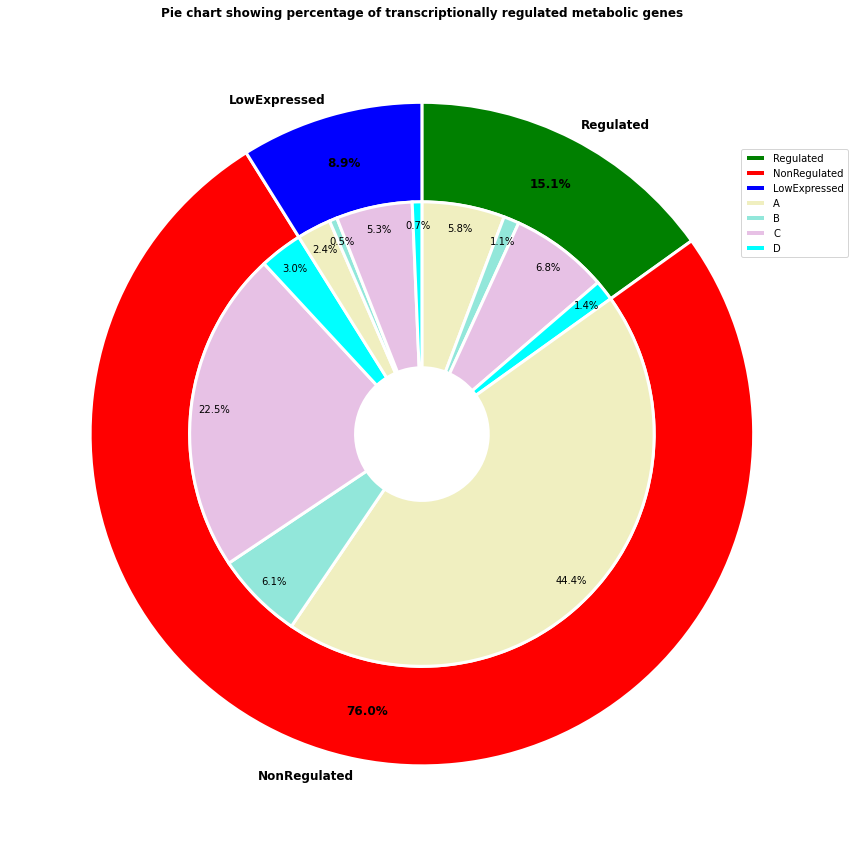

In [92]:

fig, ax = plt.subplots(figsize=(15,12))
size = 0.3
vals = np.array([regulated_vals,non_regulated_vals,low_expressed_vals])
outer_labels=["Regulated","NonRegulated","LowExpressed"]
inner_labels = classes
print(inner_labels)
print(vals)
explode = (0.1, 0)
cmap = plt.get_cmap("tab20c")
outer_colors = ['green','red','blue']
inner_colors = ['#F0EFC0','#92E7DA','#E7C1E5','cyan','#F0EFC0','#92E7DA','#E7C1E5','cyan','#F0EFC0','#92E7DA','#E7C1E5','cyan']
inner_explode=(0.1,0.1,0.1,0.1,0,0,0,0)
ax.pie(vals.sum(axis=1), radius=1, labels=outer_labels, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w',linewidth=3),shadow=False,
       textprops={'size': 'larger','fontweight':'bold'},
      pctdistance=0.85,labeldistance=1.05,startangle=90,counterclock=False,autopct='%1.1f%%')

ax.pie(vals.flatten(),radius=1-size, colors= inner_colors, labeldistance=0.5,autopct='%1.1f%%',
       wedgeprops=dict(width=0.5, edgecolor='w',linewidth='3'),pctdistance=0.90,startangle=90,counterclock=False)
plt.legend(loc='upper right',bbox_to_anchor=(1.02, 0.85),labels=outer_labels+inner_labels)
ax.set_title("Pie chart showing percentage of transcriptionally regulated metabolic genes",pad=3,fontweight="bold",fontsize=12)
plt.tight_layout()
plt.savefig("TranscriptionalRegulationDevtNoLabels.svg")
plt.show()

0.15
[1885, 299, 213]


WormBaseID
WBGene00009146    0.150021
WBGene00010665    0.150090
WBGene00018674    0.150209
WBGene00000113    0.150237
WBGene00007355    0.150389
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 1885, dtype: float64

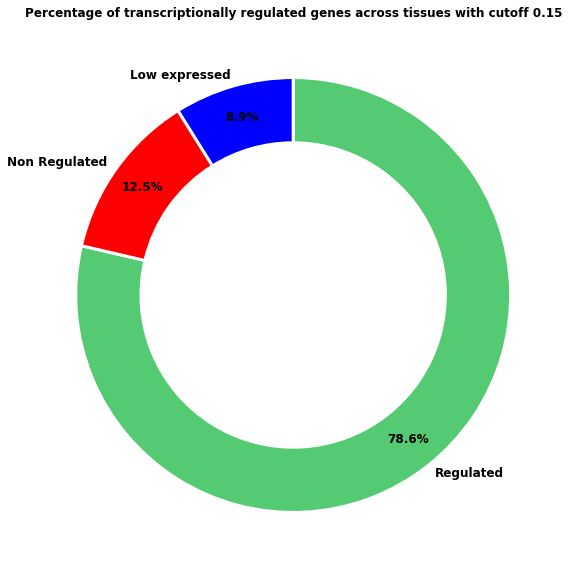

In [93]:
#Cutoff 0.15
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.15)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.3
[1096, 1088, 213]


WormBaseID
WBGene00011164    0.300199
WBGene00022629    0.300670
WBGene00002497    0.300957
WBGene00011830    0.301450
WBGene00000767    0.301933
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 1096, dtype: float64

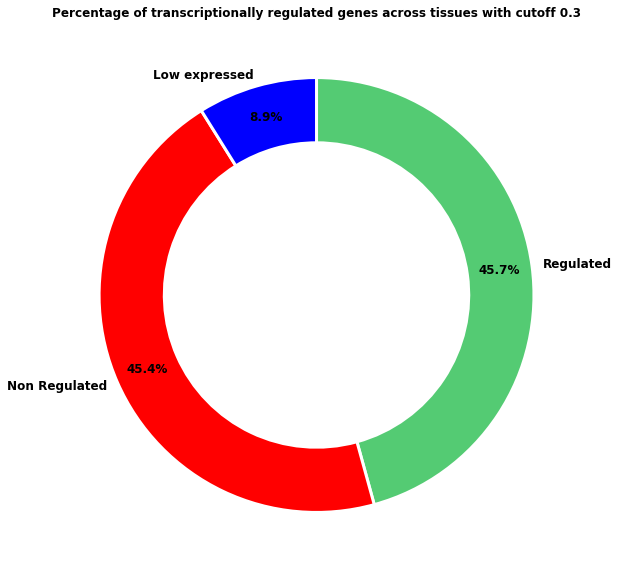

In [94]:
#Cutoff 0.3
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.3)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.45
[750, 1434, 213]


WormBaseID
WBGene00009818    0.450577
WBGene00008706    0.452081
WBGene00008167    0.455777
WBGene00017440    0.457615
WBGene00001636    0.457786
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 750, dtype: float64

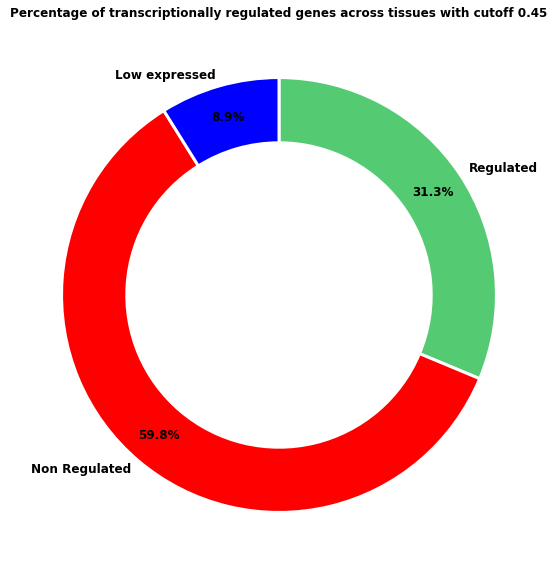

In [95]:
#Cutoff 0.45
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.45)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.6
[521, 1663, 213]


WormBaseID
WBGene00017333    0.601269
WBGene00010243    0.602427
WBGene00001553    0.602725
WBGene00020593    0.605891
WBGene00018365    0.607421
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 521, dtype: float64

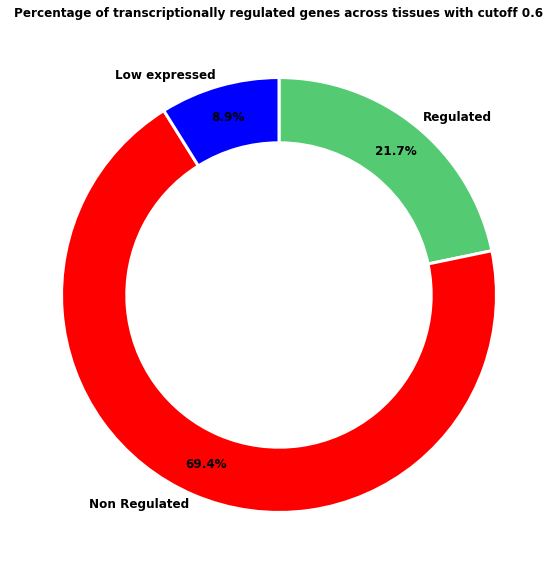

In [96]:
#Cutoff 0.6
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.6)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.75
[362, 1822, 213]


WormBaseID
WBGene00004933    0.751816
WBGene00009218    0.753103
WBGene00013865    0.753729
WBGene00000986    0.753987
WBGene00015400    0.754248
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 362, dtype: float64

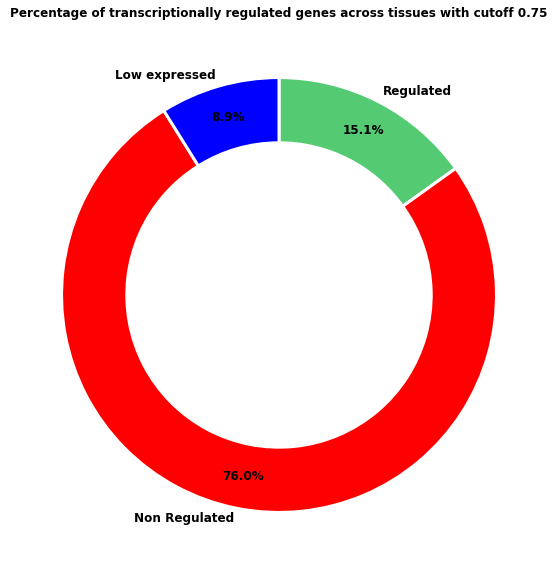

In [97]:
#Cutoff 0.75
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.75)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

0.9
[232, 1952, 213]


WormBaseID
WBGene00022814    0.900741
WBGene00018873    0.903362
WBGene00011644    0.904731
WBGene00000980    0.908353
WBGene00014206    0.909281
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 232, dtype: float64

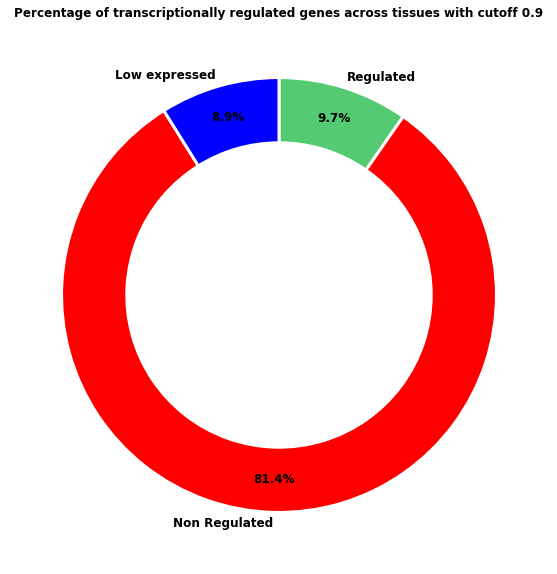

In [98]:
#Cutoff 0.9
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=0.9)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.05
[170, 2014, 213]


WormBaseID
WBGene00007517    1.052810
WBGene00012750    1.056947
WBGene00004959    1.061653
WBGene00008490    1.063679
WBGene00008905    1.075923
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 170, dtype: float64

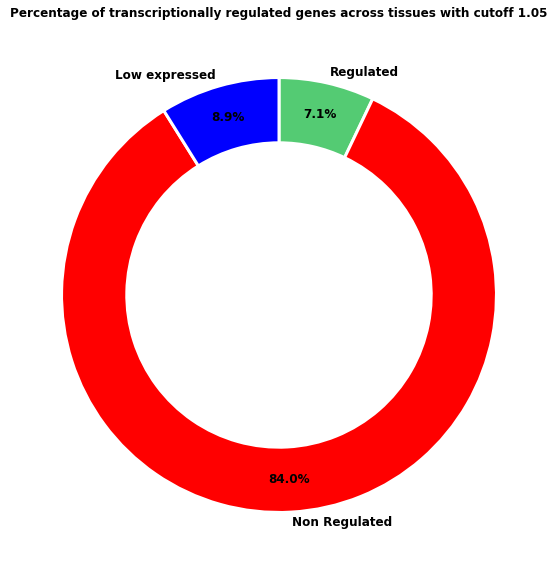

In [99]:
#Cutoff 1.05
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=1.05)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

1.2
[137, 2047, 213]


WormBaseID
WBGene00008485    1.224735
WBGene00017060    1.233695
WBGene00020674    1.235395
WBGene00014009    1.247107
WBGene00019565    1.249535
                    ...   
WBGene00001782    2.878493
WBGene00018143    2.902142
WBGene00017659    2.997630
WBGene00010790    3.721106
WBGene00009221    3.746349
Name: CoefVar, Length: 137, dtype: float64

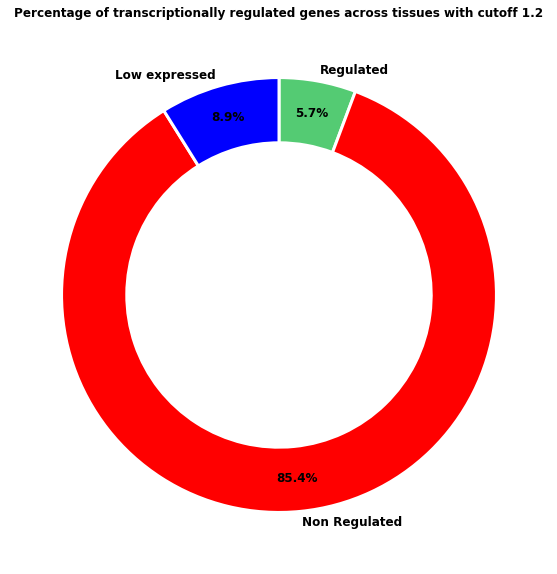

In [100]:
#Cutoff 1.2
CoefVar_1,cutoff=Cutoff(CoefVar_HighMod=MetabolicCoefVar,cutoff=1.2)
PlotRegulatedMetabolic(val1=CoefVar_1.shape[0],cutoff=cutoff,lowexpressed=metaboliclowexpressed.shape[0],HighMod=Metabolic_HighMod_Class)
CoefVar_1=CoefVar_1.CoefVar.sort_values(ascending=True)
CoefVar_1

In [101]:
RegulatedMetabolic=gene_to_wb(RegulatedMetabolic)
NonRegulated_Metabolic=gene_to_wb(NonRegulated_Metabolic)
MetabolicClasses

,Sequence Name,Class,Molecular Function,iCEL1273 description / Notes,Wormbase Description Text
Gene Name,,,,,
WBGene00017071,D2096.3,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-1 is an ortholog of human SI (sucrase-iso...
WBGene00019895,R05F9.12,A,Maltase glucoamylase,Galactose metabolism; Starch and sucrose metab...,aagr-2 is an ortholog of human SI (sucrase-iso...
WBGene00009583,F40F9.6,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-3 is an ortholog of human GANC (glucosida...
WBGene00018682,F52D1.1,A,Maltase glucoamylase,N-Glycan biosynthesis,aagr-4 is an ortholog of human GANC (glucosida...
WBGene00000001,Y110A7A.10,A,phosphoinositide 3-kinase,Inositol phosphate metabolism,aap-1 encodes the C. elegans ortholog of the p...
...,...,...,...,...,...
WBGene00009078,F23B2.13,A,NaN,NaN,NaN
WBGene00000366,R10E11.1,A,NaN,NaN,NaN
WBGene00016603,C43E11.3,A,NaN,NaN,NaN


In [102]:
RegulatedMetabolic

,Class,CV
Gene Name,,
WBGene00001782,C,2.878493
WBGene00019970,C,1.633305
WBGene00011757,A,0.862694
WBGene00017964,D,0.840990
WBGene00020386,C,1.313467
...,...,...
WBGene00009232,A,0.951653
WBGene00014241,C,2.343564
WBGene00008485,A,1.224735


In [103]:
MetabolicClasses.to_csv("MetabolicClasses_August_SN_082820.csv")

In [104]:
cutoff=0.75
RegulatedMetabolic.to_csv("RegulatedMetabolicTissue_CV{}.csv".format(cutoff))
NonRegulated_Metabolic.to_csv("NonRegulatedTissue_CV{}.csv".format(cutoff))
metaboliclowexpressed.to_csv("LowExpressedTissue.csv")